## Segmentation of Cell Images using FPN and Keras

We will implement a FPN (Feature Pyramid Networks) using Keras for image segmentation. 
Sources:
- "Feature Pyramid Networks for Object Detection", Lin et al.
- "U-Net: Convolutional Networks for Biomedical Image Segmentation", O. Ronneberger et al.  
- Other source: https://github.com/jocicmarko/ultrasound-nerve-segmentation

In [1]:
import keras
import os
import pathlib
import matplotlib
import matplotlib.image
import matplotlib.pyplot
import sklearn.model_selection
#requires also h5py for saving the model

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [3]:
ground_truth_dir = os.path.expanduser("~/ML_Segmentation_data/GroundTruth/")
images_dir = os.path.expanduser("~/ML_Segmentation_data/Images/")

In [4]:
img_file_extension = ".TIF"
image_names = os.listdir(ground_truth_dir)
image_names = [x for x in image_names if x.endswith(img_file_extension)]

In [5]:
#List of couples ground truth image - raw image
image_paths = [(ground_truth_dir + im, images_dir + im) for im in image_names]

In [6]:
#Check if all the couples have a corresponding file name and that the shape is the expected one
expected_shape = (520, 696)
cropped_size = (512, 688)

def read_img_double(path, crop_size = None):
    img = matplotlib.image.imread(path)
    out = keras.backend.cast_to_floatx(img)
    if(crop_size is None):
        return out
    return out[0 : crop_size[0], 0 : crop_size[1]]  
    
def check_file(path):
    file_handle = pathlib.Path(path)
    if not file_handle.is_file():
        raise IOError(path + " does not exist!") 
    img = read_img_double(path)
    if img.shape != expected_shape:
        raise IOError(path + " inconsistent shape! It has shape " + str(img.shape))


        
def check_files_exist(couples):
    for a,b in couples:
        check_file(a)
        check_file(b)
    print("All files, both raws and ground truth exist and have correct dimensions")

In [7]:
 check_files_exist(image_paths)

All files, both raws and ground truth exist and have correct dimensions


In [8]:
#Divide train and test set
train_imgs, test_imgs =  sklearn.model_selection.train_test_split(image_paths, test_size = 0.2)

In [9]:
print(len(train_imgs) + len(test_imgs))
print(len(image_paths))
print(len(train_imgs))

1200
1200
960


(512, 688)


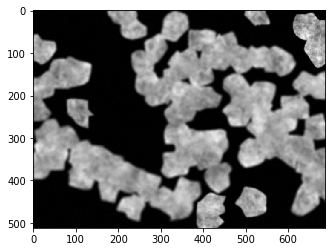

In [10]:
#show raw image
img = read_img_double(train_imgs[0][1], cropped_size)
imgplot = matplotlib.pyplot.imshow(img, cmap = 'gray')
print (img.shape)

(512, 688)


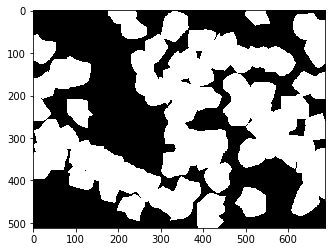

In [11]:
#show ground truth
img = read_img_double(train_imgs[0][0], cropped_size)
imgplot = matplotlib.pyplot.imshow(img, cmap = 'gray')
print (img.shape)

In [12]:
#the images are float32 matrixes as the keras backend is
img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [13]:
def create_contracting_layer(input_layer, kernel_size, downsample, filter_num):
    activation_function_pyramid = 'relu'
    conv_layer = keras.layers.Conv2D(filter_num, kernel_size, padding='same',
                                     activation = activation_function_pyramid)(input_layer)
    return keras.layers.MaxPooling2D(downsample, padding="valid")(conv_layer)

def create_expanding_layer(corresponding_layer_in_contracting_pyramid, previous_layer_expanding_pyramid, 
                           kernel_size, downsample, filter_num):
    
    activation_function_pyramid = 'relu'
    corresponding_layer_in_contracting_pyramid = keras.layers.Conv2D(filter_num, kernel_size, padding='same',
                                     activation = activation_function_pyramid)(corresponding_layer_in_contracting_pyramid)

    if(previous_layer_expanding_pyramid is None):
        return keras.layers.UpSampling2D(downsample)(corresponding_layer_in_contracting_pyramid)
    
    prev_layer = keras.layers.Concatenate(axis = 3)([corresponding_layer_in_contracting_pyramid, 
                                             previous_layer_expanding_pyramid])
    prev_layer = keras.layers.Conv2D(filter_num, kernel_size, padding='same',
                                     activation = activation_function_pyramid)(prev_layer)
    
    prev_layer = keras.layers.UpSampling2D(downsample)(prev_layer)
    return prev_layer

In [14]:
base_contracting_pyramid = keras.layers.Input(shape = (cropped_size[0], cropped_size[1], 1))

In [15]:
downsample = [2, 2]
kernel_size = [3, 3]
filter_num = 16

contracting_layer1 = create_contracting_layer(base_contracting_pyramid, kernel_size, downsample, filter_num)
contracting_layer2 = create_contracting_layer(contracting_layer1, kernel_size, downsample, filter_num * 2)
contracting_layer3 = create_contracting_layer(contracting_layer2, kernel_size, downsample, filter_num * 4)
contracting_layer4 = create_contracting_layer(contracting_layer3, kernel_size, downsample, filter_num * 8)

expanding_layer4  = create_expanding_layer(contracting_layer4, None,             kernel_size, downsample, filter_num * 8)
expanding_layer3  = create_expanding_layer(contracting_layer3, expanding_layer4, kernel_size, downsample, filter_num * 4)
expanding_layer2  = create_expanding_layer(contracting_layer2, expanding_layer3, kernel_size, downsample, filter_num * 2)
expanding_layer1  = create_expanding_layer(contracting_layer1, expanding_layer2, kernel_size, downsample, filter_num)

out_layer =  keras.layers.Conv2D(1, [1, 1], padding = 'same', activation = "sigmoid")(expanding_layer1)
model = keras.models.Model(inputs = [base_contracting_pyramid], outputs = [out_layer])


In [16]:
model.compile(optimizer='adam',
              loss="binary_crossentropy",
             metrics=['accuracy'])

In [17]:
#load images for training x -> input, y -> expected output
import numpy
import keras.preprocessing.image

def read_img_as_numpy_arr(path):
    return keras.preprocessing.image.img_to_array(read_img_double(path, cropped_size))

#Get Training Data
data = numpy.array([read_img_as_numpy_arr(img_path[1]) for img_path  in train_imgs])
labels = numpy.array([read_img_as_numpy_arr(img_path[0]) for img_path  in train_imgs])

In [18]:
#Get Test Data
test_raws = numpy.array([read_img_as_numpy_arr(img_path[1]) for img_path  in test_imgs])
test_labl = numpy.array([read_img_as_numpy_arr(img_path[0]) for img_path  in test_imgs])

In [19]:
model.fit(data, labels, epochs = 10, batch_size = 64, verbose = 2, shuffle = True)

Epoch 1/10
 - 809s - loss: -9.3048e+02 - acc: 0.2660
Epoch 2/10
 - 782s - loss: -9.3216e+02 - acc: 0.7020
Epoch 3/10
 - 768s - loss: -9.3239e+02 - acc: 0.7244
Epoch 4/10
 - 766s - loss: -9.3248e+02 - acc: 0.7305
Epoch 5/10
 - 770s - loss: -9.3253e+02 - acc: 0.7337
Epoch 6/10
 - 733s - loss: -9.3256e+02 - acc: 0.7361
Epoch 7/10
 - 754s - loss: -9.3259e+02 - acc: 0.7381
Epoch 8/10
 - 765s - loss: -9.3257e+02 - acc: 0.7359
Epoch 9/10
 - 745s - loss: -9.3258e+02 - acc: 0.7379
Epoch 10/10
 - 750s - loss: -9.3261e+02 - acc: 0.7394


In [20]:
model.save("test_model.h5")